In [1]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.utils import shuffle
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder 
import time

In [2]:
class DatasetParser():
    def __init__(self):
        self.csv_path = 'IsLotDataset/path_and_labels.csv'
        self.IMAGE_PATH_KEY = 'image_path'
        self.IS_LOT_KEY = 'is_lot'
        self.split = 1000
       
    
    def load(self):
        df = self.load_origin_dataframe()
        image_paths = df[self.IMAGE_PATH_KEY].tolist()
        images = np.array([mpimg.imread('IsLotDataset/'+path)/255.0 for path in image_paths])
        images = images.reshape(images.shape[0],images.shape[1],images.shape[2],1)
        labels = np.array(df[self.IS_LOT_KEY].tolist())
        labels = labels.reshape(len(labels),1)
        images, labels = self.unison_shuffled_copies(images, labels)
        onehotencoder = OneHotEncoder()
        labels = onehotencoder.fit_transform(labels).toarray()
        return (images[0:self.split], labels[0:self.split], images[self.split:], labels[self.split:])
    
    def unison_shuffled_copies(self, a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

        
    def load_origin_dataframe(self):
        if os.path.exists(self.csv_path):
            df = pd.read_csv(self.csv_path, sep=',')
            return df
        else:
            print('Could not load '+ORIGIN_CSV)
            return None
        

In [3]:
parser = DatasetParser()

(train_imgs, train_labels, test_imgs, test_labels) = parser.load()

In [4]:
print()
print("X daya Shape: {}".format(train_imgs.shape))
print("Image Shape: {}".format(train_imgs[0].shape))
print("Y data Shape: {}".format(train_labels.shape))
print("Label Shape: {}".format(train_labels[0].shape))
print()
print("Training Set:   {} samples".format(len(train_imgs)))
print("Test Set:       {} samples".format(len(test_imgs)))


X daya Shape: (1000, 128, 128, 1)
Image Shape: (128, 128, 1)
Y data Shape: (1000, 2)
Label Shape: (2,)

Training Set:   1000 samples
Test Set:       95 samples


In [5]:
class ImprovedLenet5():

    def __init__(self, classes, learning_rate=0.0005):

        tf.reset_default_graph()
        
        self.learning_rate = learning_rate
        self.X = tf.placeholder(tf.float32, (None, 128, 128, 1), name='input')
        self.Y = tf.placeholder(tf.float32, [None, classes], name='labels')
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')

        mu = 0
        sigma = 0.1

        #Layer 1: Convolutional. Input = 128x128x1. Output = 124x124x8.
        conv1_w = tf.Variable(tf.truncated_normal(shape = [5,5,1,8],mean = mu, stddev = sigma))
        conv1_b = tf.Variable(tf.zeros(8))
        conv1 = tf.nn.conv2d(self.X,conv1_w, strides = [1,1,1,1], padding = 'VALID') + conv1_b 
        conv1 = tf.nn.relu(conv1)

        #Pooling. Input = 124x124x8. Output = 62x62x8.
        pool_1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')

        #Layer 2: Convolutional. Output = 58x58x16.
        conv2_w = tf.Variable(tf.truncated_normal(shape = [5,5,8,16], mean = mu, stddev = sigma))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2 = tf.nn.conv2d(pool_1, conv2_w, strides = [1,1,1,1], padding = 'VALID') + conv2_b
        conv2 = tf.nn.relu(conv2)

        #Pooling. Input = 58x58x16. Output = 29x29x16.
        pool_2 = tf.nn.max_pool(conv2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID') 

        #Flatten. Input = 13x13x16. Output = 13456.
        fc1 = flatten(pool_2)

        #Layer 3: Fully Connected. Input = 2.704. Output = 256.
        fc1_w = tf.get_variable("fc1_w", shape=[13456,256],
                                initializer=tf.contrib.layers.xavier_initializer())
        fc1_b = tf.Variable(tf.zeros(256))
        fc1 = tf.matmul(fc1,fc1_w) + fc1_b
        fc1 = tf.nn.relu(fc1)
        fc1 = tf.nn.dropout(fc1, self.keep_prob)
        

        #Layer 4: Fully Connected. Input = 256. Output = 128.
        fc2_w = tf.get_variable("fc2_w", shape=[256,128],
                                initializer=tf.contrib.layers.xavier_initializer())
        fc2_b = tf.Variable(tf.zeros(128))
        fc2 = tf.matmul(fc1,fc2_w) + fc2_b
        fc2 = tf.nn.relu(fc2)
        fc2 = tf.nn.dropout(fc2, self.keep_prob)

        #Layer 5: Fully Connected. Input = 128. Output = 64.
        fc3_w = tf.get_variable("fc3_w", shape=[128,64],
                                initializer=tf.contrib.layers.xavier_initializer())
        fc3_b = tf.Variable(tf.zeros(64))
        fc3 = tf.matmul(fc2,fc3_w) + fc3_b
        fc3 = tf.nn.relu(fc3)
        fc3 = tf.nn.dropout(fc3, self.keep_prob)

        #Layer 6: Fully Connected. Input = 64. Output = classes.
        fc4_w = tf.get_variable("fc4_w", shape=[64,classes],
                                initializer=tf.contrib.layers.xavier_initializer())
        fc4_b = tf.Variable(tf.zeros(classes))
        self.logits = tf.matmul(fc3, fc4_w) + fc4_b
        self.output = tf.nn.softmax(self.logits, axis=1)
        self.output = tf.identity(self.output, name="output")

        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.Y)
        self.loss_operation = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        self.training_operation = optimizer.minimize(self.loss_operation)

        correct_prediction = tf.equal(tf.argmax(self.logits, axis=1), tf.argmax(self.Y, axis=1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        
        self.session = tf.Session()
        self.saver = tf.train.Saver()
        self.session.run(tf.global_variables_initializer())

        tf.train.write_graph(self.session.graph_def, "./export", "network.pb", False)


    def fit(self, x_data, y_data, batch_size, num_epochs, x_test, y_test):
        
        num_iterations = int(x_data.shape[0]/batch_size)
        historic_accuracy = np.zeros(num_epochs)
        historic_accuracy_test = np.zeros(num_epochs)
        historic_loss = np.zeros(num_epochs)

        print("Training...")
        print()
        for epoch in range(num_epochs):
            x_data_s, y_data_s = shuffle(x_data, y_data)

            for iteration in range(num_iterations):
                batch_xs = x_data_s[iteration*batch_size:(iteration+1)*batch_size,:]
                batch_ys = y_data_s[iteration*batch_size:(iteration+1)*batch_size,:]
                _ = self.session.run([self.training_operation], feed_dict={self.X: batch_xs, self.Y: batch_ys, self.keep_prob: 0.7})
            
            accuracy_val, loss_val = self.session.run([self.accuracy, self.loss_operation], feed_dict={self.X: batch_xs, self.Y: batch_ys, self.keep_prob: 1.0})
            historic_accuracy[epoch] = accuracy_val
            historic_loss[epoch] = loss_val
            historic_accuracy_test[epoch] = self.compute_accuracy(x_test, y_test)
            print('Epoch:', '%03d' % (epoch + 1), 'training acc: {}, test acc: {}, loss: {}'.format(accuracy_val, historic_accuracy_test[epoch], loss_val))

        print("Learning Finished!")
        self.saver.save(self.session, "./export/is_lot_checkpoints")
        return historic_accuracy, historic_accuracy_test, historic_loss

    def predict(self, x_data):
        output_values = self.session.run(tf.nn.softmax(self.logits, axis=1), feed_dict={self.X: x_data, self.keep_prob: 1.0})
        return output_values

    def compute_accuracy(self, x_data, y_data):
        accuracy_val = self.session.run(self.accuracy, feed_dict={self.X: x_data, self.Y: y_data, self.keep_prob: 1.0})
        return accuracy_val
    
    def speed_test(self, x_data):
        time1 = time.time()
        [self.predict(image.reshape(1,image.shape[0],image.shape[1],image.shape[2])) for image in x_data]
        enlapsed = (time.time()-time1)*1000
        print('Test took {:.3f} ms to predict {} images'.format(enlapsed, len(x_data)))
        print('Single inference took {:.3f} ms'.format(enlapsed/len(x_data)))


In [6]:
net = ImprovedLenet5(classes=2, learning_rate=0.0004)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [7]:
acc, acc_test, loss = net.fit(x_data=train_imgs,
                              y_data=train_labels,
                              batch_size=200,
                              num_epochs=12,
                              x_test=test_imgs,
                              y_test=test_labels)

Training...

Epoch: 001 training acc: 0.6549999713897705, test acc: 0.6842105388641357, loss: 0.6014127731323242
Epoch: 002 training acc: 0.7149999737739563, test acc: 0.800000011920929, loss: 0.6255220770835876
Epoch: 003 training acc: 0.7300000190734863, test acc: 0.7789473533630371, loss: 0.587007462978363
Epoch: 004 training acc: 0.7599999904632568, test acc: 0.7684210538864136, loss: 0.5041592121124268
Epoch: 005 training acc: 0.7699999809265137, test acc: 0.821052610874176, loss: 0.4738016426563263
Epoch: 006 training acc: 0.8100000023841858, test acc: 0.8105263113975525, loss: 0.4120982885360718
Epoch: 007 training acc: 0.8399999737739563, test acc: 0.8315789699554443, loss: 0.35456544160842896
Epoch: 008 training acc: 0.8149999976158142, test acc: 0.8315789699554443, loss: 0.3837119936943054
Epoch: 009 training acc: 0.8450000286102295, test acc: 0.8421052694320679, loss: 0.3513893783092499
Epoch: 010 training acc: 0.8700000047683716, test acc: 0.8315789699554443, loss: 0.312962

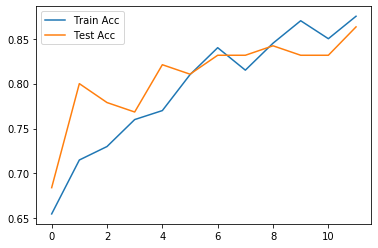

In [8]:
plt.plot(acc, label='Train Acc')
plt.plot(acc_test, label='Test Acc')
plt.legend(loc="upper left")

[[0.01960961 0.98039037]]
[0. 1.]


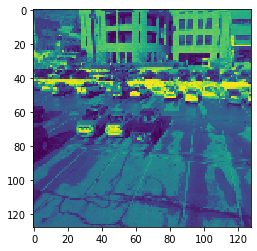

In [9]:
index = 32

sample = test_imgs[index].reshape(1, 128, 128, 1)
labl = test_labels[index]

out = net.predict(x_data=sample)
print(out)
print(labl)

plt.imshow(sample[0,:,:,0])

In [10]:
net.speed_test(x_data=test_imgs)

Test took 3843.686 ms to predict 95 images
Single inference took 40.460 ms


In [11]:
import freeze_graph

_ = freeze_graph.freeze_graph(input_graph='export/network.pb',
                                  input_saver='',
                                  input_binary=True,
                                  input_checkpoint='export/is_lot_checkpoints',
                                  output_node_names='output',
                                  restore_op_name='save/restore_all',
                                  filename_tensor_name='save/Const:0',
                                  output_graph='export/is_lot_frozen_network.pb',
                                  clear_devices=True, 
                                  initializer_nodes='')

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from export/is_lot_checkpoints
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 12 variables.
INFO:tensorflow:Converted 12 variables to const ops.


In [ ]:
class _IsLotCNN(object):

    def __init__(self, model_filepath='export/is_lot_frozen_network.pb'):
        self.model_filepath = model_filepath
        self.load_graph(model_filepath = self.model_filepath)

    def load_graph(self, model_filepath):
        self.graph = tf.Graph()
        self.sess = tf.InteractiveSession(graph = self.graph)

        with tf.gfile.GFile(model_filepath, 'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())

        # Define input tensor
        self.input = tf.placeholder(np.float32, shape = [None, 128, 128, 1], name='input')
        self.keep_prob = tf.placeholder(tf.float32, name='keep_prob')

        tf.import_graph_def(graph_def, {'input': self.input, 'keep_prob': self.keep_prob})

    def predict(self, data):

        # Know your output node name
        output_tensor = self.graph.get_tensor_by_name("import/output:0")
        output = self.sess.run(output_tensor, feed_dict = {self.input: data, self.keep_prob: 1.0})

        return output

In [ ]:
cnn = _IsLotCNN()

array([[0.01960961, 0.98039037]], dtype=float32)

In [ ]:
from is_lot_cnn import IsLotCNN
lotCNN = IsLotCNN()
lotCNN.predict(sample)

/Users/guillemgbt/Development/Thesis/thesis_env/lib/python3.6/site-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


array([[0.13109161, 0.86890846]], dtype=float32)

load graph
Instructions for updating:
Use tf.gfile.GFile.


array([[0.13109161, 0.86890846]], dtype=float32)

(1, 128, 128, 1)

0.8526315789473684